In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    pi = 3.141592
    c = 3e8
    e = 1.6e-19

class setup:
    dummy = 0

### Monochromator calibration

In [3]:
calibration_data = mipt.read_excel('data/511.ods', usecols=('A', 'B'), header=(0, 1))
calibration_data = calibration_data['Calibration']
calibration_data

,lambda,N
0,7032.0,2946.0
1,6929.0,2920.0
2,6717.0,2855.0
3,6678.0,2842.0
4,6599.0,2817.0
5,6533.0,2792.0
6,6507.0,2783.0
7,6402.0,2745.0
8,6383.0,2739.0
9,6334.0,2720.0


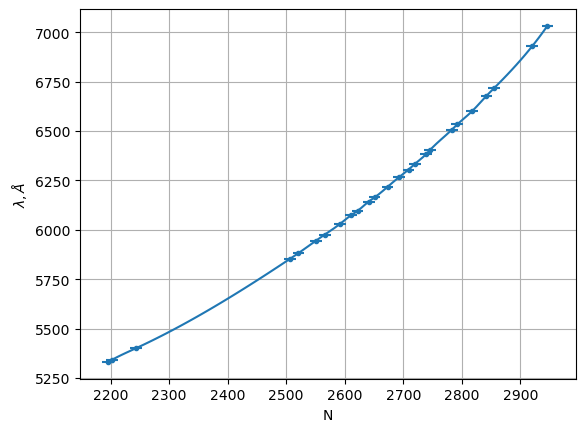

In [4]:
def interp(x, y):
    return sp.interpolate.interp1d(x, y, kind='cubic')

_, _, N2wavelen = mipt.plot(calibration_data['N'], calibration_data['lambda'], func=interp, xerr=10)

plt.xlabel(r'N')
plt.ylabel(r'$\lambda, \AA$')
plt.grid(True)
plt.savefig('gen/calibration.pdf')

### I(V) for different wavelengths

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.086667,0.003667,0.279052,0.010686,0.006242,1.702443,0.047797,0.426597,0.005053


N=2908, V_0 = (-0.251 +- 0.008) В


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.388333,0.032336,0.310746,0.02377,0.027711,0.85698,0.006509,0.64354,0.002786


N=2244, V_0 = (-0.751 +- 0.007) В


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.194692,0.011987,0.277132,0.032813,0.019809,1.652475,0.024618,0.598856,0.005499


N=2783, V_0 = (-0.362 +- 0.006) В


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.251538,0.016413,0.274778,0.035651,0.02418,1.473207,0.012643,0.645347,0.003569


N=2709, V_0 = (-0.438 +- 0.004) В


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.258333,0.025797,0.321528,0.04462,0.033835,1.311584,0.030634,0.660354,0.009319


N=2641, V_0 = (-0.503 +- 0.014) В


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.343462,0.022067,0.272362,0.033511,0.027162,1.230911,0.017793,0.695133,0.006658


N=2566, V_0 = (-0.565 +- 0.010) В


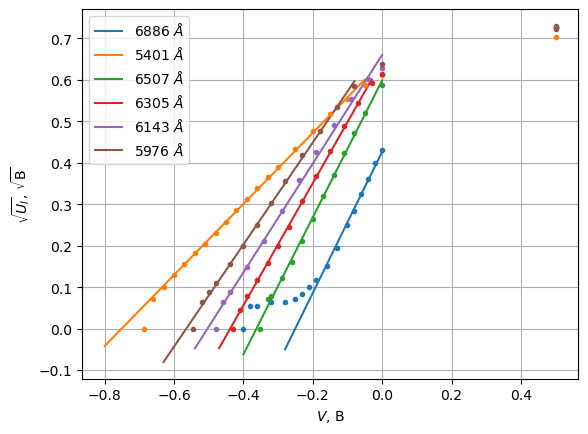

In [13]:

output = []
def process(cols, begin, end, begin_interp, end_interp, x_min):
    data = mipt.read_excel('data/511.ods', usecols=(cols), header=(0, 1))
    # Extract N from header
    m = re.compile(r"N=(\d+)")
    result = m.match(data.columns[0][0])
    assert result != None, "Wrong header syntax"
    N = int(result.group(1))

    # Remove top header
    data = data[f'N={N}']
    U_v = list(data['U_close'][begin:end])
    U_i = list(data['U_i'    ][begin:end])

    # Evaluate wavelen according to calibration
    wavelen = float(N2wavelen(N))
    
    U_v_clean, U_i_clean, equ = mipt.plot(U_v, np.sqrt(U_i), begin=begin_interp, end=end_interp, x_min=x_min,
                                          label="{:.0f} $\AA$".format(wavelen))
    
    res = mipt.mnk(U_v_clean, U_i_clean).data
    display(res)
    V_0 = - float(res['b'] / res['a'])
    V_0_err = abs(V_0) * float(* np.sqrt((res['db']/res['b'])**2 + (res['da']/res['a'])**2))

    output.append([wavelen, V_0, V_0_err])

    print("N={}, V_0 = ({:0.3f} +- {:0.3f}) В".format(N, V_0, V_0_err))

process(('D', 'E'), 0, 18, 8, 16, -0.28)
process(('G', 'H'), 0, 21, 1, 18, -0.8)
process(('J', 'K'), 0, 14, 0, 12, -0.4)
process(('M', 'N'), 0, 15, 0, 12, -0.47)
process(('P', 'Q'), 0, 13, 0, 11, -0.54)
process(('S', 'T'), 0, 15, 0, 12, -0.63)
# process(('M', 'N'), 0, None, 0, None, None)

plt.xlabel(r'$V$, В')
plt.ylabel(r'$\sqrt{U_I}$, $\sqrt{\mathrm{В}}$')
plt.legend()
plt.grid(True)
plt.savefig('gen/iv.pdf')


### V_0(omega)

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,3.056097e+15,5.489635e+28,0.478364,0.024891,3.679820e+13,6.703215e-16,3.196361e-17,-1.570204,0.097971


W ~ 1.57 эВ, hbar = (1.07 +- 0.05)e-34 Дж*с


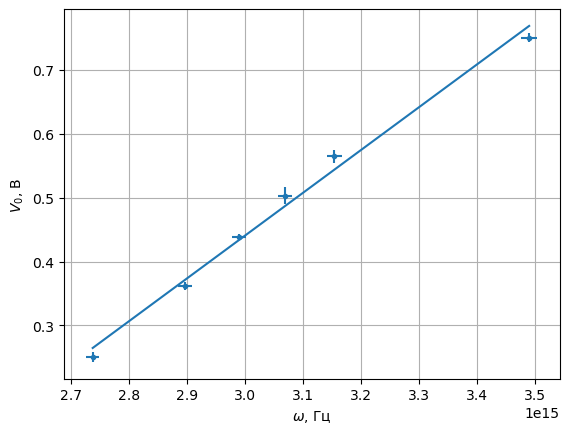

In [16]:
# Unzip output
wavelen, V_0, V_0_err = [np.array(i) for i in zip(*output)]

omega = (2 * np.pi * consts.c) / (wavelen / 1.0e10)

wavelen_clean, V_0_clean, _ = mipt.plot(omega, abs(V_0), yerr=V_0_err, xerr=10/2500*omega)

plt.xlabel(r"$\omega$, Гц")
plt.ylabel(r"$V_0$, В")
plt.grid(True)
plt.savefig('gen/v0_omega.pdf')

mnk = mipt.mnk(wavelen_clean, V_0_clean).data
display(mnk)

hbar = float(mnk['a']) * consts.e
hbar_err = float(mnk['da']/mnk['a']) * hbar
W = - float(mnk['b']) # эВ

print("W ~ {:.2f} эВ, hbar = ({:.2f} +- {:.2f})e-34 Дж*с".format(W, hbar*1e34, hbar_err*1e34))

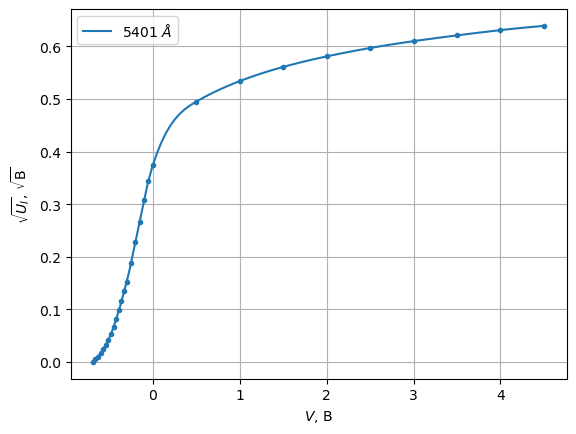

In [24]:

def interp(x, y):
    return sp.interpolate.interp1d(x, y, kind='cubic')

def process(cols, begin, end, begin_interp, end_interp, x_min):
    data = mipt.read_excel('data/511.ods', usecols=(cols), header=(0, 1))
    # Extract N from header
    m = re.compile(r"N=(\d+)")
    result = m.match(data.columns[0][0])
    assert result != None, "Wrong header syntax"
    N = int(result.group(1))

    # Remove top header
    data = data[f'N={N}']
    U_v = list(data['U_close'][begin:end])
    U_i = list(data['U_i'    ][begin:end])

    # Evaluate wavelen according to calibration
    wavelen = float(N2wavelen(N))
    
    U_v_clean, U_i_clean, equ = mipt.plot(U_v, U_i, begin=begin_interp, end=end_interp, x_min=x_min,
                                          label="{:.0f} $\AA$".format(wavelen), func=interp)

process(('D', 'E'), 0, None, 0, None, None)
process(('G', 'H'), 0, None, 0, None, None)
process(('J', 'K'), 0, None, 0, None, None)
process(('M', 'N'), 0, None, 0, None, None)
process(('P', 'Q'), 0, None, 0, None, None)
process(('S', 'T'), 0, None, 0, None, None)
# process(('M', 'N'), 0, None, 0, None, None)

plt.xlabel(r'$V$, В')
plt.ylabel(r'$\sqrt{U_I}$, $\sqrt{\mathrm{В}}$')
plt.legend()
plt.grid(True)
plt.savefig('gen/iv_full.pdf')
